## Data analysis notebook with PPO algo hyperparameter choices

In [3]:
import glob
import os
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

PARAM_GRID = {
    'learning_rate': [2.5e-5, 2.5e-4, 2.5e-3],
    'total_timesteps': [25000, 50000, 75000],
    'num_steps': [256, 1024],
    'gae': [True, False],
    'norm_adv': [True, False],
    "normalize_env": [True, False],
    "anneal_lr": [True, False],
}

os.chdir("/Users/apple/Documents/reinforcement_learning/final_project/")

n_exp = glob.glob(os.path.join("models/ppo2/", '*'))
df_all = []
for i in tqdm(range(len(n_exp))):
    path = f"models/ppo2/hyperparam_{i}"
    with open(os.path.join(path, "hyper_params.json")) as f:
        config = json.load(f)
    #keep only hyperparams that we do grid search
    filtered_config = {key: value for key, value in config.items() if key in PARAM_GRID.keys()}
    
    df_hyperparam = pd.DataFrame.from_dict(filtered_config, orient='index').T
    df_hyperparam["exp"] = f"hyperparam_{i}"
    files = glob.glob(os.path.join(path, "*/*.csv"))
    df_return_list = []
    for idx, file in enumerate(files):
        run_num = file.split("/")[-1].split('.')[0].split("_")[-1]
        df_return = pd.read_csv(file)
        df_return = df_return.reset_index().rename(columns={"index":"step", "0": "cum_return"})
        df_return["run"] = run_num
        df_return_list.append(df_return)
    
    df_return_all = pd.concat(df_return_list, ignore_index=True)
    df_return_all = df_return_all.join(df_hyperparam).ffill()
    df_all.append(df_return_all)

df_all = pd.concat(df_all, ignore_index=True)

100%|██████████| 288/288 [00:01<00:00, 197.39it/s]


In [2]:
df_all.head()

,step,cum_return,run,learning_rate,total_timesteps,num_steps,anneal_lr,gae,norm_adv,normalize_env,exp
0,0,1.000000,run2,0.000025,25000,256,True,True,True,True,hyperparam_0
1,1,0.975415,run2,0.000025,25000,256,True,True,True,True,hyperparam_0
2,2,0.979943,run2,0.000025,25000,256,True,True,True,True,hyperparam_0
3,3,0.979371,run2,0.000025,25000,256,True,True,True,True,hyperparam_0
4,4,0.986667,run2,0.000025,25000,256,True,True,True,True,hyperparam_0


In [3]:
#compute the top 5 cum returns on validation data 
df_cumret = df_all[df_all["step"] == df_all["step"].max()].sort_values(["cum_return"], ascending=False)
df_cumret.head(5)

,step,cum_return,run,learning_rate,total_timesteps,num_steps,anneal_lr,gae,norm_adv,normalize_env,exp
454663,352,2.921354,run3,0.0025,75000,256,False,True,True,True,hyperparam_257
476196,352,2.588476,run1,0.0025,75000,256,False,False,False,True,hyperparam_269
504436,352,2.511490,run1,0.0025,75000,1024,False,False,False,True,hyperparam_285
461723,352,2.402557,run3,0.0025,75000,256,False,True,False,True,hyperparam_261
341703,352,2.377440,run3,0.0025,25000,256,False,True,True,True,hyperparam_193


In [4]:
#compute the bottom 5 cum returns on validation data 
df_cumret.tail(5)

,step,cum_return,run,learning_rate,total_timesteps,num_steps,anneal_lr,gae,norm_adv,normalize_env,exp
229449,352,0.892994,run0,0.00025,50000,256,False,True,True,True,hyperparam_129
412303,352,0.889414,run3,0.00250,50000,256,False,False,True,True,hyperparam_233
448309,352,0.864143,run0,0.00250,50000,1024,False,False,False,True,hyperparam_253
412656,352,0.838111,run1,0.00250,50000,256,False,False,True,True,hyperparam_233
342409,352,0.791893,run0,0.00250,25000,256,False,True,True,True,hyperparam_193


In [19]:
df_list = []
params = ["learning_rate", "total_timesteps", "num_steps", "anneal_lr", "gae", "norm_adv", "normalize_env"]
for param in params:
    df_param = pd.melt(df_cumret.groupby(param)["cum_return"].quantile(.95).reset_index(), 
            id_vars=['cum_return'], var_name='hyperparam')
    df_list.append(df_param)

df_params = pd.concat(df_list, ignore_index=True)


In [30]:
df_params

,cum_return,hyperparam,value
0,1.657780,learning_rate,0.000025
1,1.723740,learning_rate,0.000250
2,1.841181,learning_rate,0.002500
3,1.724202,total_timesteps,25000.000000
4,1.708995,total_timesteps,50000.000000
5,1.833353,total_timesteps,75000.000000
6,1.782159,num_steps,256.000000
7,1.668578,num_steps,1024.000000
8,1.773716,anneal_lr,0.000000
9,1.723280,anneal_lr,1.000000


Text(0.5, 1.0, 'Histogram of cum_return for different anneal_lr groups')

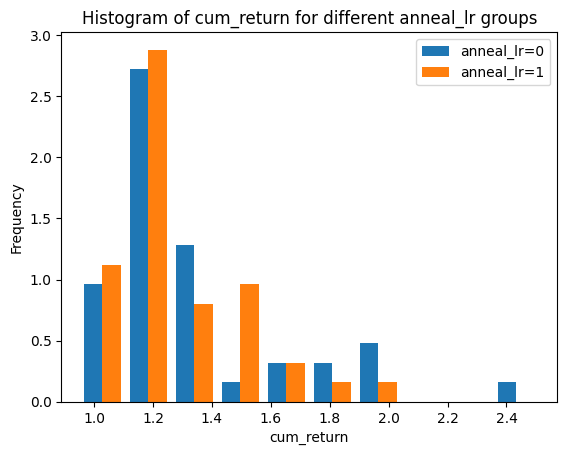

In [33]:
df_cumret_gp = df_cumret.groupby(["learning_rate","total_timesteps", "num_steps","anneal_lr", "gae", "norm_adv", "normalize_env"]).agg({"cum_return": ["mean","max","min"]}).reset_index()
df_cumret_gp.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in df_cumret_gp.columns]
df_cumret_gp_max = df_cumret[(df_cumret["learning_rate"] == 0.0025) & (df_cumret["total_timesteps"] == 75000) & (df_cumret["num_steps"] == 1024)]

plt.hist([df_cumret_gp_max[df_cumret_gp_max['anneal_lr'] == 0]['cum_return'],
          df_cumret_gp_max[df_cumret_gp_max['anneal_lr'] == 1]['cum_return']],
          label=['anneal_lr=0', 'anneal_lr=1'], density=True)
plt.xlabel('cum_return')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of cum_return for different anneal_lr groups')

Text(0.5, 1.0, 'Histogram of cum_return for different norm_env groups')

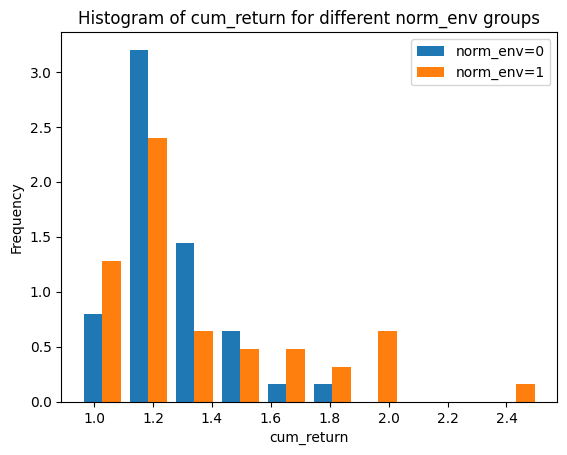

In [34]:
plt.hist([df_cumret_gp_max[df_cumret_gp_max['normalize_env'] == 0]['cum_return'],
          df_cumret_gp_max[df_cumret_gp_max['normalize_env'] == 1]['cum_return']],
          label=['norm_env=0', 'norm_env=1'], density=True)
plt.xlabel('cum_return')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of cum_return for different norm_env groups')

Text(0.5, 1.0, 'Histogram of cum_return for different gae groups')

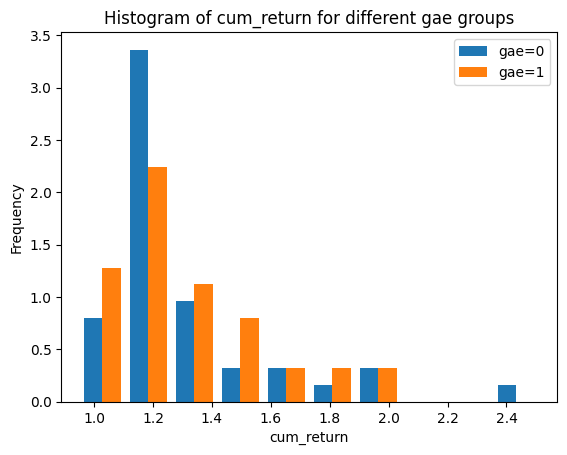

In [35]:
plt.hist([df_cumret_gp_max[df_cumret_gp_max['gae'] == 0]['cum_return'],
          df_cumret_gp_max[df_cumret_gp_max['gae'] == 1]['cum_return']],
          label=['gae=0', 'gae=1'], density=True)
plt.xlabel('cum_return')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of cum_return for different gae groups')

Text(0.5, 1.0, 'Histogram of cum_return for different norm_adv groups')

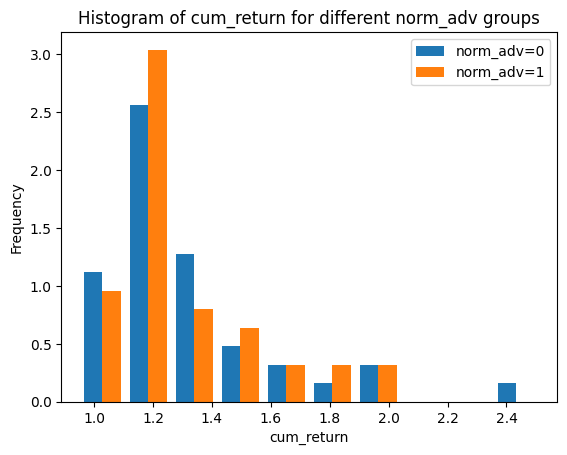

In [36]:
plt.hist([df_cumret_gp_max[df_cumret_gp_max['norm_adv'] == 0]['cum_return'],
          df_cumret_gp_max[df_cumret_gp_max['norm_adv'] == 1]['cum_return']],
          label=['norm_adv=0', 'norm_adv=1'], density=True)
plt.xlabel('cum_return')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of cum_return for different norm_adv groups')